In [13]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from math import sqrt

# Install required packages if needed
!pip install -q tensorflow scikit-learn xgboost haversine seaborn

# For pretty plots
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Import from other modules
from dataset_loader import load_dataset, split_dataset
from preprocessing import preprocess_data
from kalman_filter import apply_kalman_filter

# Import enhanced models and evaluation functions
from enhanced_ml_models import get_model, reshape_for_rnn, get_callbacks
from enhanced_evaluation import (
    evaluate_model, plot_trajectory, plot_error_distribution,
    plot_comparison_results, plot_tradeoff_analysis, 
    haversine_distance, drift_per_km
)

# Import TensorFlow but don't show the warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [14]:
# Load dataset
dataset_path = "IMU.csv"
df = load_dataset(dataset_path)

# Display dataset info
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())
print("\nDataset summary:")
display(df.describe())

# Extract features and labels
X_train, X_test, y_train, y_test = split_dataset(df)

# Preprocess data
X_train_prep, X_test_prep, scaler = preprocess_data(X_train, X_test)

# Apply Kalman filtering to GPS labels (optional, for baseline)
filtered_positions = apply_kalman_filter(df)

print(f"\nTraining set: {X_train_prep.shape}, Target: {y_train.shape}")
print(f"Testing set: {X_test_prep.shape}, Target: {y_test.shape}")

Dataset shape: (10304, 14)

First few rows:


,time,ax,ay,az,wx,wy,wz,Bx,By,Bz,latitude,longitude,altitude,speed
0,2025-02-13 05:43:04.801000+00:00,-0.2775,0.0240,0.5453,-0.2692,-0.2876,0.0531,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
1,2025-02-13 05:43:04.804000+00:00,-0.2775,0.0240,0.5453,-0.1753,-0.1668,0.1018,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
2,2025-02-13 05:43:04.812000+00:00,-0.0585,-0.1047,0.6579,0.0630,0.0344,0.0687,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
3,2025-02-13 05:43:04.822000+00:00,0.1941,-0.1942,0.6870,0.1577,0.0861,0.0053,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0
4,2025-02-13 05:43:04.833000+00:00,0.4528,-0.1449,0.5582,0.2020,0.1025,-0.0629,-30.9249,29.025,-25.3177,12.861826,77.66471,925.0079,-1.0



Dataset summary:


,ax,ay,az,wx,wy,wz,Bx,By,Bz,latitude,longitude,altitude,speed
count,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,10304.000000,1.030400e+04,1.030400e+04,10304.0000,10304.000000,10304.000000,10304.000000,10304.000000
mean,0.023179,-0.105303,0.023924,-0.001318,-0.009015,-0.028880,-3.092490e+01,2.902500e+01,-25.3177,12.861894,77.664675,911.824946,0.119759
std,0.763107,0.606263,0.928822,0.313035,0.246759,0.471628,3.552886e-15,7.105772e-15,0.0000,0.000047,0.000041,7.742956,0.675668
min,-4.381300,-3.798800,-4.276000,-3.252200,-2.322800,-2.315500,-3.092490e+01,2.902500e+01,-25.3177,12.861801,77.664573,907.067200,-1.000000
25%,-0.210525,-0.240825,-0.307200,-0.082025,-0.067400,-0.110800,-3.092490e+01,2.902500e+01,-25.3177,12.861859,77.664637,907.295400,0.000000
50%,0.005750,-0.040600,-0.003700,-0.003400,-0.003400,-0.004050,-3.092490e+01,2.902500e+01,-25.3177,12.861892,77.664683,907.301500,0.358600
75%,0.237125,0.103150,0.276300,0.076300,0.057000,0.094300,-3.092490e+01,2.902500e+01,-25.3177,12.861940,77.664704,925.007900,0.594325
max,4.234700,2.417600,8.981600,2.884100,1.930600,2.929100,-3.092490e+01,2.902500e+01,-25.3177,12.861981,77.664766,925.532200,1.388500



Training set: (8243, 9), Target: (8243, 2)
Testing set: (2061, 9), Target: (2061, 2)


In [15]:
# Convert data to sequences for RNN models
timesteps = 10
X_train_seq = reshape_for_rnn(X_train_prep, timesteps=timesteps)
X_test_seq = reshape_for_rnn(X_test_prep, timesteps=timesteps)
y_train_seq = y_train[timesteps:]
y_test_seq = y_test[timesteps:]

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print(f"Input shape for sequence models: {input_shape}")

Input shape for sequence models: (10, 9)


In [16]:
def evaluate_deep_model(model_name, X_train, y_train, X_test, y_test, 
                        epochs=50, batch_size=32, is_sequence_model=True):
    """Train and evaluate a model with timing and detailed metrics."""
    
    print(f"\n{'='*50}\nTraining {model_name}...\n{'='*50}")
    
    # Get the model
    if is_sequence_model:
        model = get_model(model_name, input_shape)
    else:
        model = get_model(model_name)
    
    # Setup callbacks
    callbacks = get_callbacks()
    
    # Train with timing
    start_time = time.time()
    
    if model_name == "ensemble":
        # For the ensemble model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                 validation_split=0.1, verbose=1)
    elif is_sequence_model:
        # For deep learning sequence models
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=1, callbacks=callbacks)
    elif model_name in ["xgboost", "gradient_boosting", "knn", "random_forest", "svr"]:
        # For traditional ML models
        model.fit(X_train, y_train)
        
    training_time = time.time() - start_time
    
    # Predict with timing
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Evaluate and plot
    metrics = evaluate_model(y_test, y_pred, model_name, 
                           inference_time=inference_time,
                           training_time=training_time)
    
    return model, y_pred, metrics

In [17]:
results = []

In [18]:
# ---------- GRU + SVR (GRU-SVR) ----------
# This cell trains a small GRU encoder to extract sequence features, then fits an sklearn SVR (wrapped
# for multi-output) on those features. Finally it computes the same metrics used elsewhere and appends
# the GRU-SVR row to the `results` list / results_df shown under "Comprehensive Comparative Analysis".

# NOTE: relies on these notebook variables/functions already being available:
#   X_train_seq, X_test_seq, y_train_seq, y_test_seq, results
#   haversine_distance (optional) and drift_per_km (optional) from enhanced_evaluation
# If any helper isn't available, the code falls back to simple computations.

import time
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1) GRU encoder definition ---
feature_dim = 64   # dimensionality of features passed to SVR
gru_units = 128
epochs_gru = 30
batch_size = 32

gru_encoder = keras.Sequential([
    layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    layers.GRU(gru_units, return_sequences=False, name="gru_encoder"),
    layers.Dense(feature_dim, activation="relu", name="feature_dense")
], name="GRU_encoder")

gru_encoder.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=1e-3)
)

# --- 2) Train GRU encoder as a predictor (so it learns useful features) ---
# We'll add a small head for training to predict the target, then remove it to use the encoder outputs.
# Create a temporary model (encoder + regression head) for training:
reg_head = layers.Dense(y_train_seq.shape[-1], activation="linear", name="reg_head")
temp_input = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = layers.GRU(gru_units, return_sequences=False)(temp_input)
feat = layers.Dense(feature_dim, activation="relu")(x)
out = reg_head(feat)
temp_model = keras.Model(temp_input, out, name="GRU_with_head")
temp_model.compile(optimizer=optimizers.Adam(1e-3), loss="mse")

es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

start_time = time.time()
temp_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=epochs_gru,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)
gru_training_time = time.time() - start_time

# After training, extract the trained encoder weights into our encoder model:
# (we can reuse layers from temp_model)
# Build encoder that maps input -> feature vector
encoder_layer_names = [layer.name for layer in temp_model.layers]
# get references to trained layers (assumes architecture order matches)
# Create an encoder model by reusing sub-layers (safer than trying to copy weights manually)
encoder_input = temp_model.inputs[0]
# find the tensor corresponding to the feature Dense layer in temp_model
# In the temp_model above, layer index -2 is the Dense(feature_dim); use the name to locate it.
feature_tensor = temp_model.get_layer(index=-2).output
encoder_model = keras.Model(encoder_input, feature_tensor, name="trained_encoder")

# --- 3) Extract features for train and test sets ---
start_time = time.time()
X_train_feats = encoder_model.predict(X_train_seq, batch_size=batch_size, verbose=0)
X_test_feats = encoder_model.predict(X_test_seq, batch_size=batch_size, verbose=0)
feature_extraction_time = time.time() - start_time

# --- 4) Train SVR on extracted features ---
# SVR doesn't natively support multi-output; wrap it.
svr = MultiOutputRegressor(SVR(C=1.0, kernel="rbf", gamma="scale", max_iter=10000))
start_time = time.time()
svr.fit(X_train_feats, y_train_seq)
svr_training_time = time.time() - start_time

total_training_time = gru_training_time + svr_training_time

# --- 5) Inference (measure time) ---
start_time = time.time()
svr_preds = svr.predict(X_test_feats)
inference_time = time.time() - start_time

# --- 6) Compute metrics (RMSE, MAE, R2, avg_distance_error, drift_per_km) ---
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
rmse_val = rmse(y_test_seq, svr_preds)
mae_val = mean_absolute_error(y_test_seq, svr_preds)
r2_val = r2_score(y_test_seq, svr_preds)

# avg_distance_error: try to use haversine_distance if available; otherwise use Euclidean on coords
try:
    # expect haversine_distance to accept two arrays of shape (n_samples, 2) and return distances in meters
    avg_dist = np.mean(haversine_distance(y_test_seq, svr_preds))
except Exception:
    # fallback: euclidean (meters if coordinates pre-scaled), else same units as y
    avg_dist = np.mean(np.linalg.norm(y_test_seq - svr_preds, axis=1))

# drift_per_km: try to call provided helper; fallback to None
try:
    drift_val = drift_per_km(y_test_seq, svr_preds)
except Exception:
    drift_val = None

# --- 7) Prepare metrics dict and append to results ---
gru_svr_metrics = {
    "model": "GRU-SVR",
    "RMSE": float(rmse_val),
    "MAE": float(mae_val),
    "R2": float(r2_val),
    "avg_distance_error": float(avg_dist),
    "drift_per_km": float(drift_val) if drift_val is not None else None,
    "inference_time": float(inference_time),
    "training_time": float(total_training_time)
}

# Append to results (the notebook earlier converted results -> results_df)
results.append(gru_svr_metrics)

# Update & display results DataFrame if results_df exists / create if not
import pandas as pd
try:
    results_df = pd.DataFrame(results)
except Exception:
    results_df = pd.DataFrame([gru_svr_metrics])

display(results_df[['model', 'RMSE', 'MAE', 'R2', 'avg_distance_error', 'drift_per_km', 'inference_time', 'training_time']])


Epoch 1/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1620.1310 - val_loss: 2.5196
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1833 - val_loss: 1.9308
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0099 - val_loss: 1.9337
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - val_loss: 1.9371
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0021 - val_loss: 1.9394
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - val_loss: 1.9411
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - val_loss: 1.9433
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - val_loss: 1.9445
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 2.


,model,RMSE,MAE,R2,avg_distance_error,drift_per_km,inference_time,training_time
0,GRU-SVR,0.000044,0.000031,-0.513992,0.006021,162.6318,0.007811,20.370919


In [19]:
# ---------- GRU + XGBoost (GRU-XGBoost) ----------
# Similar setup to GRU-SVR, but replaces SVR with XGBoost for nonlinear boosted regression.

import time
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1) GRU encoder (same feature extraction structure as GRU-SVR) ---
feature_dim = 64
gru_units = 128
epochs_gru = 30
batch_size = 32

gru_encoder_xgb = keras.Sequential([
    layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    layers.GRU(gru_units, return_sequences=False, name="gru_encoder"),
    layers.Dense(feature_dim, activation="relu", name="feature_dense")
], name="GRU_encoder_xgb")

gru_encoder_xgb.compile(
    loss="mse",
    optimizer=optimizers.Adam(learning_rate=1e-3)
)

# --- 2) Train GRU encoder temporarily as predictor ---
temp_input = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = layers.GRU(gru_units, return_sequences=False)(temp_input)
feat = layers.Dense(feature_dim, activation="relu")(x)
out = layers.Dense(y_train_seq.shape[-1], activation="linear")(feat)
temp_model_xgb = keras.Model(temp_input, out, name="GRU_with_head_xgb")
temp_model_xgb.compile(optimizer=optimizers.Adam(1e-3), loss="mse")

es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

start_time = time.time()
temp_model_xgb.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=epochs_gru,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)
gru_training_time_xgb = time.time() - start_time

# --- 3) Extract features using trained encoder ---
encoder_model_xgb = keras.Model(temp_model_xgb.input, temp_model_xgb.layers[-2].output)
X_train_feats_xgb = encoder_model_xgb.predict(X_train_seq, batch_size=batch_size, verbose=0)
X_test_feats_xgb = encoder_model_xgb.predict(X_test_seq, batch_size=batch_size, verbose=0)

# --- 4) Train XGBoost on extracted features ---
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

start_time = time.time()
xgb_model.fit(X_train_feats_xgb, y_train_seq)
xgb_training_time = time.time() - start_time

total_training_time_xgb = gru_training_time_xgb + xgb_training_time

# --- 5) Inference ---
start_time = time.time()
xgb_preds = xgb_model.predict(X_test_feats_xgb)
inference_time_xgb = time.time() - start_time

# --- 6) Metrics ---
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
rmse_val = rmse(y_test_seq, xgb_preds)
mae_val = mean_absolute_error(y_test_seq, xgb_preds)
r2_val = r2_score(y_test_seq, xgb_preds)

try:
    avg_dist = np.mean(haversine_distance(y_test_seq, xgb_preds))
except Exception:
    avg_dist = np.mean(np.linalg.norm(y_test_seq - xgb_preds, axis=1))

try:
    drift_val = drift_per_km(y_test_seq, xgb_preds)
except Exception:
    drift_val = None

gru_xgb_metrics = {
    "model": "GRU-XGBoost",
    "RMSE": float(rmse_val),
    "MAE": float(mae_val),
    "R2": float(r2_val),
    "avg_distance_error": float(avg_dist),
    "drift_per_km": float(drift_val) if drift_val is not None else None,
    "inference_time": float(inference_time_xgb),
    "training_time": float(total_training_time_xgb)
}

results.append(gru_xgb_metrics)

try:
    results_df = pd.DataFrame(results)
except Exception:
    results_df = pd.DataFrame([gru_xgb_metrics])

display(results_df[['model', 'RMSE', 'MAE', 'R2', 'avg_distance_error', 'drift_per_km', 'inference_time', 'training_time']])


Epoch 1/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1478.8772 - val_loss: 1.8392
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9742 - val_loss: 0.7415
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6027e-04 - val_loss: 0.7413
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.8561e-05 - val_loss: 0.7411
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.7227e-05 - val_loss: 0.7409
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.1230e-05 - val_loss: 0.7409
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.7043e-05 - val_loss: 0.7404
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.3902e-05 - val_loss: 0.7400
Epoch 9/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.0635e-05 - val_loss: 0.7398
Epoch 10/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4174e-05 - val_loss: 0.7395
Epoch 11/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.5707e-05 - val_loss: 0.7392
Epoch 12/30


,model,RMSE,MAE,R2,avg_distance_error,drift_per_km,inference_time,training_time
0,GRU-SVR,0.000044,0.000031,-0.513992,0.006021,162.631800,0.007811,20.370919
1,GRU-XGBoost,0.000063,0.000053,-1.942629,0.008628,16.377086,0.002106,74.649332


In [20]:
# ---------- BiGRU + XGBoost (BiGRU-XGBoost) ----------
# Bidirectional GRU encoder + XGBoost regressor
# Uses fixed epochs, LR decay, and saves/reloads the full model (.keras)

import time
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Hyperparameters ---
feature_dim = 64
gru_units = 128
epochs_bigru = 40
batch_size = 32
checkpoint_path = "bigru_with_head_best.keras"   # Save full model (not just weights)

# --- 1) Build BiGRU encoder + regression head ---
keras.backend.clear_session()

temp_input = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=False))(temp_input)
feat = layers.Dense(feature_dim, activation="relu")(x)
out = layers.Dense(y_train_seq.shape[-1], activation="linear")(feat)
temp_model_bigru = keras.Model(temp_input, out, name="BiGRU_with_head")

# --- 2) Learning rate schedule ---
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=False
)
opt = optimizers.Adam(learning_rate=lr_schedule)
temp_model_bigru.compile(optimizer=opt, loss="mse")

# --- 3) Checkpoint callback (save best full model) ---
cp = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# --- 4) Train model ---
start_time = time.time()
temp_model_bigru.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=epochs_bigru,
    batch_size=batch_size,
    callbacks=[cp],
    verbose=1
)
bigru_training_time = time.time() - start_time

# --- 5) Reload best saved model ---
if os.path.exists(checkpoint_path):
    temp_model_bigru = keras.models.load_model(checkpoint_path)
    print("✅ Best model reloaded from checkpoint.")

# --- 6) Extract features using the trained encoder (penultimate layer output) ---
encoder_model_bigru = keras.Model(temp_model_bigru.input, temp_model_bigru.layers[-2].output)
X_train_feats_bigru = encoder_model_bigru.predict(X_train_seq, batch_size=batch_size, verbose=0)
X_test_feats_bigru = encoder_model_bigru.predict(X_test_seq, batch_size=batch_size, verbose=0)

# --- 7) Train XGBoost regressor on extracted features ---
xgb_model_bigru = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

start_time = time.time()
xgb_model_bigru.fit(X_train_feats_bigru, y_train_seq)
xgb_training_time = time.time() - start_time

total_training_time_bigru = bigru_training_time + xgb_training_time

# --- 8) Inference & metrics ---
start_time = time.time()
xgb_preds_bigru = xgb_model_bigru.predict(X_test_feats_bigru)
inference_time_bigru = time.time() - start_time

def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
rmse_val = rmse(y_test_seq, xgb_preds_bigru)
mae_val = mean_absolute_error(y_test_seq, xgb_preds_bigru)
r2_val = r2_score(y_test_seq, xgb_preds_bigru)

try:
    avg_dist = float(np.mean(haversine_distance(y_test_seq, xgb_preds_bigru)))
except Exception:
    avg_dist = float(np.mean(np.linalg.norm(y_test_seq - xgb_preds_bigru, axis=1)))

try:
    drift_val = float(drift_per_km(y_test_seq, xgb_preds_bigru))
except Exception:
    drift_val = None

bigru_xgb_metrics = {
    "model": "BiGRU-XGBoost",
    "RMSE": float(rmse_val),
    "MAE": float(mae_val),
    "R2": float(r2_val),
    "avg_distance_error": avg_dist,
    "drift_per_km": drift_val,
    "inference_time": float(inference_time_bigru),
    "training_time": float(total_training_time_bigru)
}

# --- 9) Append to results and display ---
try:
    results
except NameError:
    results = []

results.append(bigru_xgb_metrics)

try:
    results_df = pd.DataFrame(results)
except Exception:
    results_df = pd.DataFrame([bigru_xgb_metrics])

display(results_df[['model', 'RMSE', 'MAE', 'R2', 'avg_distance_error', 'drift_per_km', 'inference_time', 'training_time']])



Epoch 1/40
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1322.2153
Epoch 1: val_loss improved from inf to 0.35504, saving model to bigru_with_head_best.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1307.4641 - val_loss: 0.3550
Epoch 2/40
228/232 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0497
Epoch 2: val_loss did not improve from 0.35504
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0500 - val_loss: 0.3567
Epoch 3/40
227/232 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289
Epoch 3: val_loss did not improve from 0.35504
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0288 - val_loss: 0.3625
Epoch 4/40
230/232 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109
Epoch 4: val_loss did not improve from 0.35504
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0109 - val_loss: 0.3654
Epoch 5/40
227/232 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077
Epoch 5: val_loss did not improve from 0.35504
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - val_loss: 0.3673
Epo

,model,RMSE,MAE,R2,avg_distance_error,drift_per_km,inference_time,training_time
0,GRU-SVR,0.000044,0.000031,-0.513992,0.006021,162.631800,0.007811,20.370919
1,GRU-XGBoost,0.000063,0.000053,-1.942629,0.008628,16.377086,0.002106,74.649332
2,BiGRU-XGBoost,0.000063,0.000053,-1.930456,0.008611,16.857092,0.002005,75.208639


In [21]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Show detailed comparison table
display(results_df[['model', 'RMSE', 'MAE', 'R2', 'avg_distance_error', 'drift_per_km', 'inference_time', 'training_time']])

,model,RMSE,MAE,R2,avg_distance_error,drift_per_km,inference_time,training_time
0,GRU-SVR,0.000044,0.000031,-0.513992,0.006021,162.631800,0.007811,20.370919
1,GRU-XGBoost,0.000063,0.000053,-1.942629,0.008628,16.377086,0.002106,74.649332
2,BiGRU-XGBoost,0.000063,0.000053,-1.930456,0.008611,16.857092,0.002005,75.208639


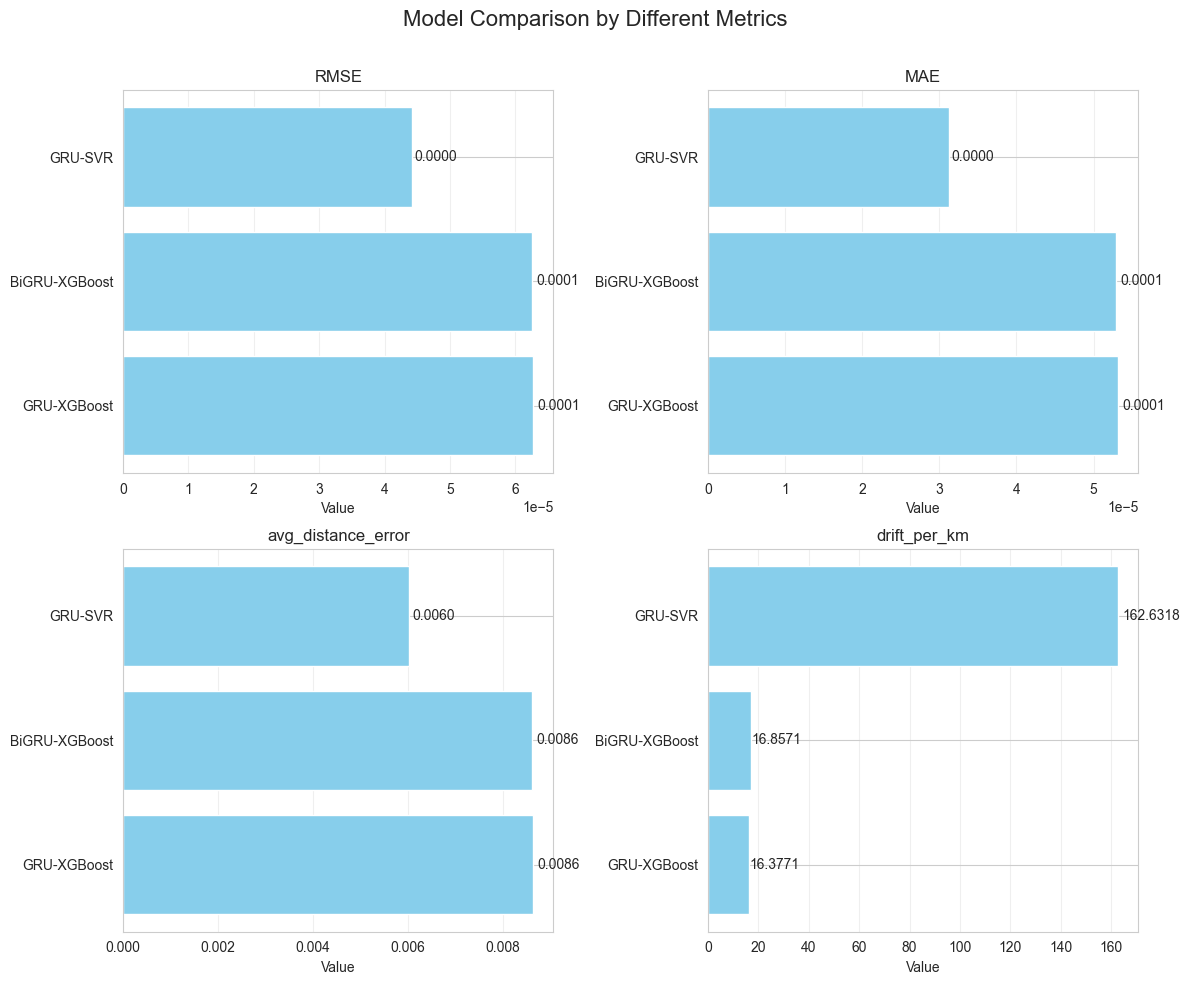

In [22]:
# Plot error metrics comparison
plot_comparison_results(results, metric_columns=['RMSE', 'MAE', 'avg_distance_error', 'drift_per_km'])

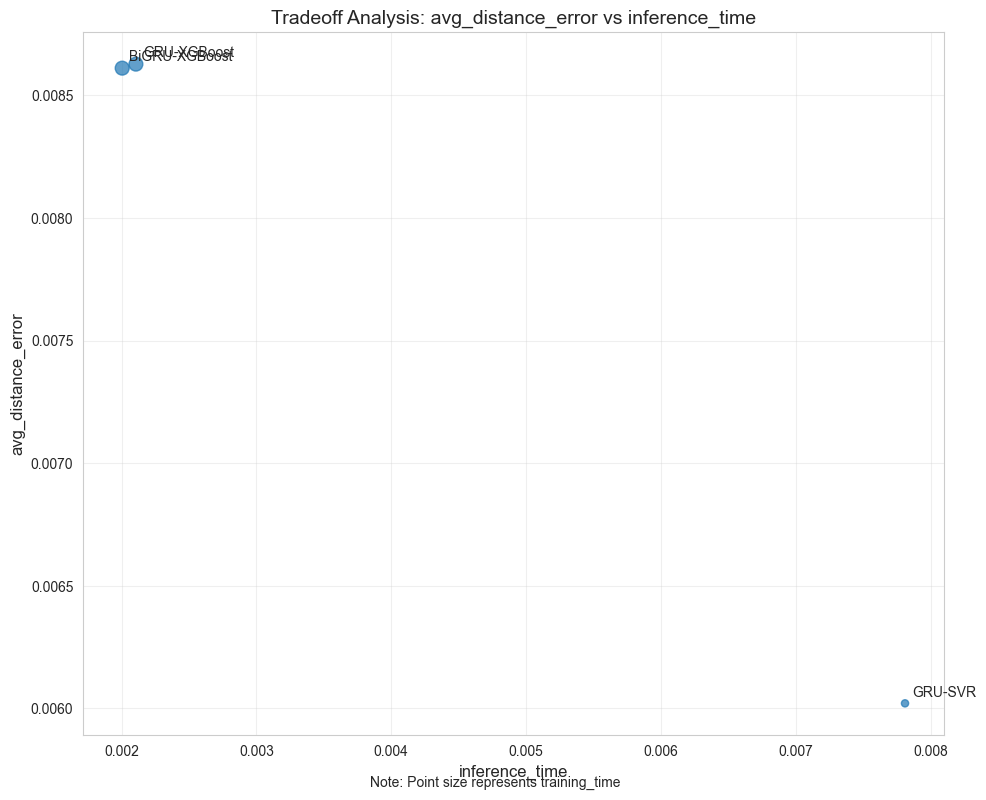

In [23]:
# Plot accuracy vs. latency tradeoff
plot_tradeoff_analysis(results, 
                       x_metric='inference_time', 
                       y_metric='avg_distance_error',
                       size_metric='training_time')

In [24]:
# Find the best model based on average distance error
best_model_idx = results_df['avg_distance_error'].idxmin()
best_model_name = results_df.loc[best_model_idx, 'model']
print(f"Best model: {best_model_name}")

Best model: GRU-SVR
